Для удобной работы с .csv файлами было решено использовать 
библиотеку Pandas. Для постройки графиков используются Matplotlib и Seaborn.


In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

<Figure size 432x288 with 0 Axes>

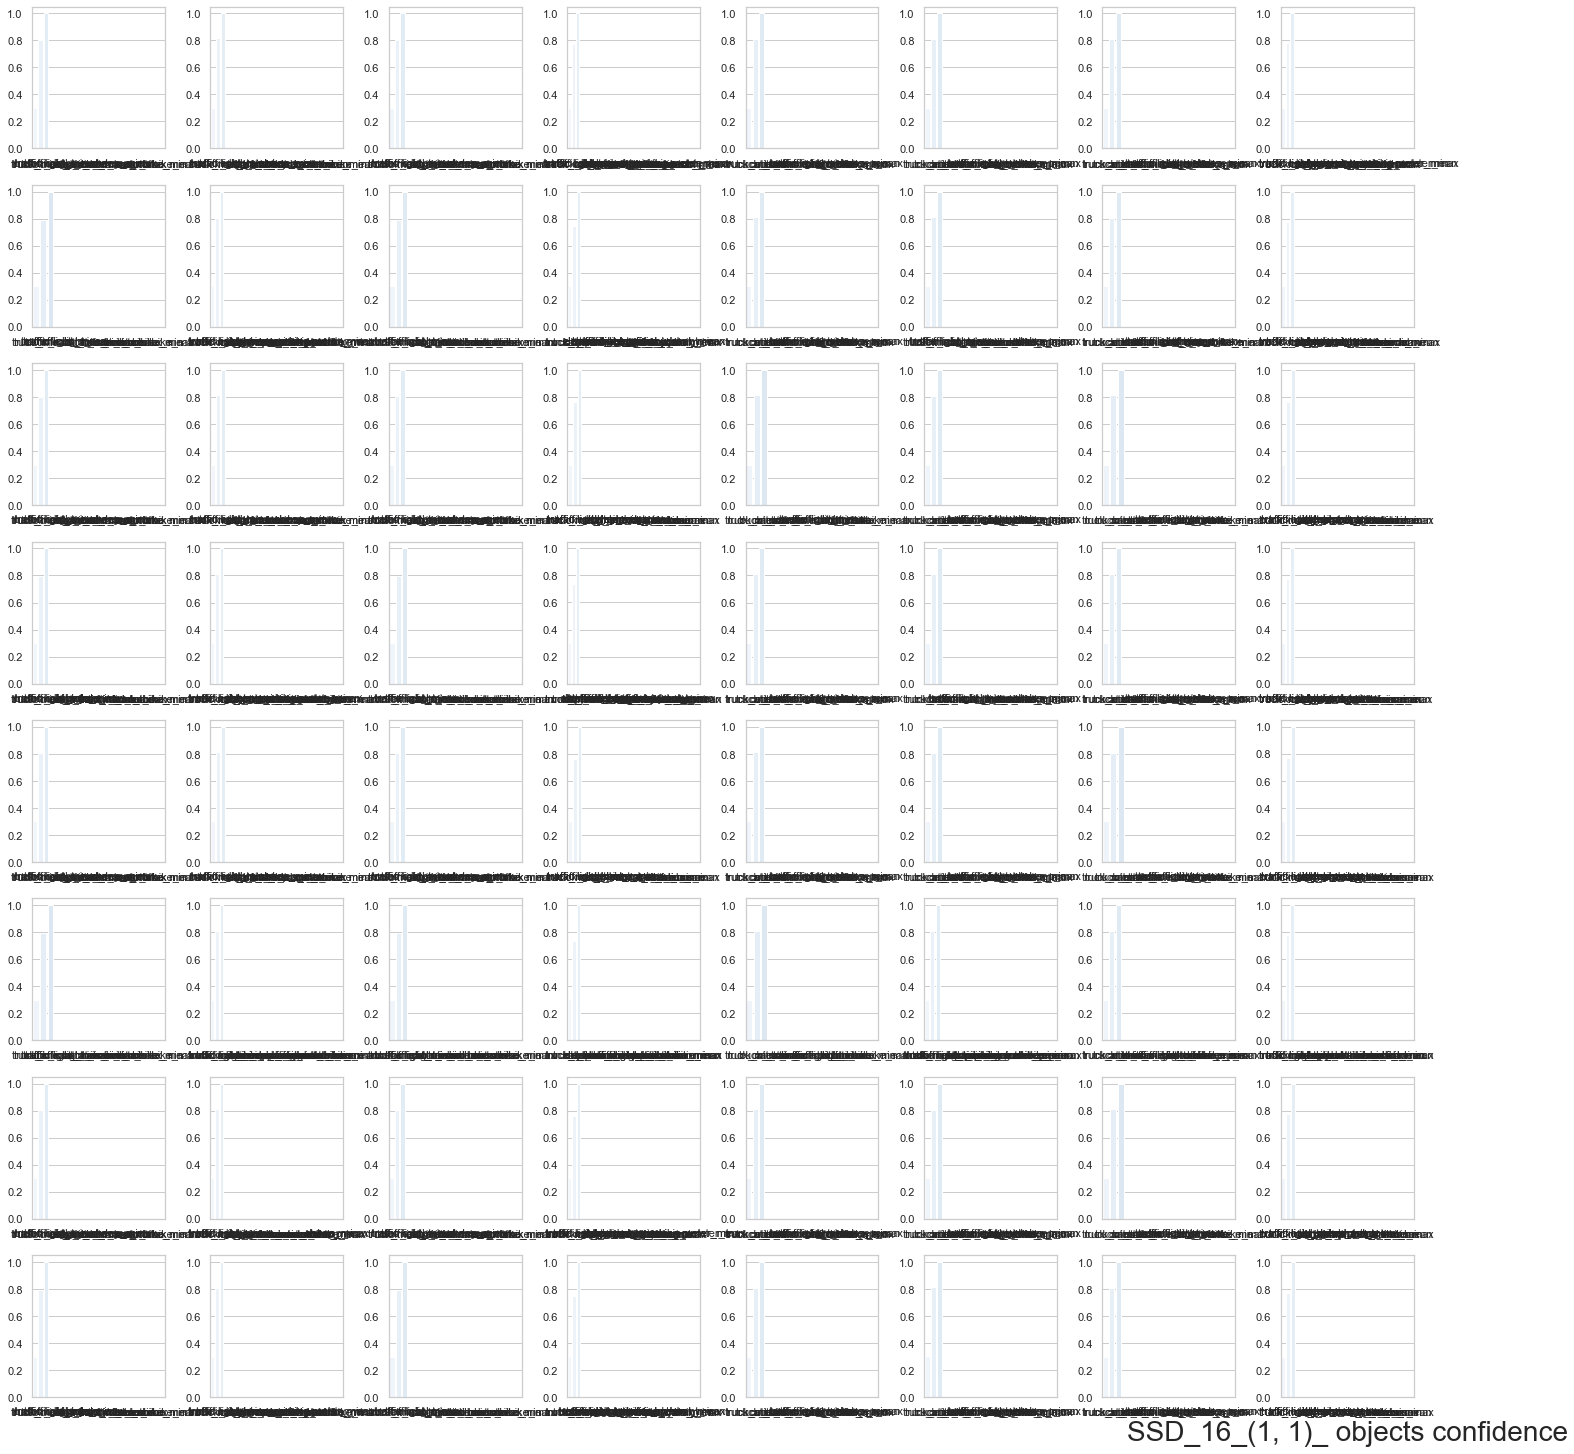

In [117]:
# List of all classes YOLO can recognize
class_names = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
                "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
                "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
                "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
                "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
                "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
                "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
                "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
                "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
                "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

tuples = list(zip(np.arange(len(class_names), dtype=float), class_names))

# Reading .csv files, dataset1 and dataset2 are generated via Data_generator.py
dataset1 = pd.read_csv('dataset1.csv', header=None, names=['Frame', 'Bbox', 'Class', 'Confidence', 'Frame_load_time'])
dataset2 = pd.read_csv('dataset2.csv', header=None, names=['Frame', 'Bbox', 'Class', 'Confidence', 'Frame_load_time'])
dataset_test = pd.read_csv('test_gaussian.csv', header=None, names=['Frame', 'Bbox', 'Class', 'Confidence', 'Frame_load_time'])

def parse_name(name):
    name = name.split('.')[0]
    nn, vid, kernel, param1, param2, param3 = name[0:len(name)].split('_')
    return nn, vid, kernel, param1, param2, param3

def print_conf_plot(dataset, ax):
    df = pd.DataFrame()
    unique_values = dataset['Class'].unique()   
    if len(unique_values) > 0:
        for i in range(len(unique_values)):
            df[unique_values[i] + '_min'] = dataset.loc[dataset['Class'] == unique_values[i]].groupby('Class').min()['Confidence']
            df[unique_values[i] + '_mean'] = dataset.loc[dataset['Class'] == unique_values[i]].groupby('Class').mean()['Confidence']
            df[unique_values[i] + '_max'] = dataset.loc[dataset['Class'] == unique_values[i]].groupby('Class').max()['Confidence']
        # print(df)
        cat_plot = sns.barplot(data=df, palette="Blues", ax=ax)
    else:
        ax.text(0.5, 0.4,'No data', fontsize=30)
    '''
    cat_plot = sns.catplot(data=df, kind='bar', ax=ax[0][0])
    cat_plot.despine(left=True)
    cat_plot.set_ylabels("confidence")
    '''
    # print(df)

def csv_reader():
    files = os.listdir('16')
    grid_size = 8
    h, w = 0, 0
    '''
    fig = plt.figure()
    sns.set(style="whitegrid")
    f, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    '''
    # for i in range(len(files)):
    # for i in range(2 * grid_size * grid_size):
    for i in (np.arange(grid_size * grid_size) + 4 * grid_size * grid_size):
        nn, vid, kernel, param1, param2, param3 = parse_name(files[i])
        dataset = pd.read_csv('16/' + files[i], header=None, names=['Frame', 'Bbox', 'Class', 'Confidence', 'Frame_load_time'])
        for t in range(len(tuples)):
            dataset = dataset.replace({'Class': tuples[t][0]}, tuples[t][1])
        
        if i % grid_size == 0 and i != 0:
            w = 0
            h = h + 1

        if i % (grid_size * grid_size) == 0:
            h, w = 0, 0
            fig = plt.figure()
            sns.set(style="whitegrid")
            f, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
            plt.tight_layout()
            plt.xlabel('_'.join([nn, vid, kernel, ' objects confidence']), fontsize=28, horizontalalignment='center')
        
        print_conf_plot(dataset, axes[h][w])
        w = w + 1
        
        #sns.despine(left=True)    
        # cat_plot = sns.barplot(data=df, ax=ax)
        # cat_plot.set_ylabels("confidence")
    
csv_reader()
pd.set_option('display.width', 100)
# pd.set_option('display.max_columns', 15)

'''
print("dataset1")
print(dataset1.describe(), '\n')
print(dataset1.head(), '\n\n')

print("dataset2")
print(dataset2.describe(), '\n')
print(dataset2.head(), '\n')


print("dataset_test")
print(dataset_test.describe(), '\n')
print(dataset_test.head(), '\n')
'''

# Replacing number values with the names of classes
for i in range(len(tuples)):
    dataset_test = dataset_test.replace({'Class': tuples[i][0]}, tuples[i][1])
# print(dataset_test.head(), '\n')


Для анализа работы нейросети было решено использовать следущие параметры:<br>
1. Количество распознанных объектов каждого класса на каждом фрейме
2. Минимальный, средний и максмальный конфиденс для каждого класса объекта на каждом фрейме

Для сравнения результатов работы нескольких нейросетей решено также сравнивать разницу координат 
баундинг боксов для каждой пары объектов, которые были определены нейросетью на обоих видео.

In [118]:
def data_conf_by_frame(dataset):
    df_min = pd.DataFrame()
    df_mean = pd.DataFrame()
    df_max = pd.DataFrame()
    unique_values = dataset['Class'].unique()
    for i in range(len(unique_values)):
        df_min[unique_values[i] + '_min_conf'] = dataset.loc[dataset['Class'] == unique_values[i]].groupby('Frame').min()['Confidence']
        df_mean[unique_values[i] + '_mean_conf'] = dataset.loc[dataset['Class'] == unique_values[i]].groupby('Frame').mean()['Confidence']
        df_max[unique_values[i] + '_max_conf'] = dataset.loc[dataset['Class'] == unique_values[i]].groupby('Frame').max()['Confidence']
    # print(df_min)
    # print(df_mean)
    # print(df_max)
    return df_min, df_mean, df_max

def data_num_obj_by_frame(dataset):
    df = pd.DataFrame()
    unique_values = dataset['Class'].unique()
    for i in range(len(unique_values)):
        df[unique_values[i] + '_num'] = dataset.loc[dataset['Class'] == unique_values[i]].groupby('Frame').count()['Class']
        # Fill NaN values, that can occur if there are no objects of that type in the frame
        df[unique_values[i] + '_num'] = df[unique_values[i] + '_num'].fillna(0).astype(int)
    # print(df)
    return df

def match(val1, val2):
    if val1 == val2:
        return True
    else:
        return False

'''
def data_bbox_by_frame(dataset_test1, dataset_test2):
    dataset_test1_cut = dataset_test1.loc[dataset_test1['Frame'] < 100]
    dataset_test2_cut = dataset_test2.loc[dataset_test2['Frame'] < 100]
    print(dataset_test2_cut.head(200))
    df = pd.DataFrame()
    unique_values = []
    
    if len(dataset_test1.index) != len(dataset_test2.index):
        print('Different length of datasets')
        return
    
    for i, j in zip(dataset_test1_cut['Class'].unique(), dataset_test2_cut['Class'].unique()):
        if i not in unique_values:
            unique_values.append(i)
        if j not in unique_values:
            unique_values.append(j)
    
    counter = 0
    bbox_list = []
    for frame in range(100):
        for index1, row1 in dataset_test1_cut.loc[dataset_test1_cut['Frame'] == frame]['Bbox'].iteritems():
            x_min1, y_min1, x_max1, y_max1 = row1[1:len(row1) - 1].split()
            for index2, row2 in dataset_test2_cut.loc[dataset_test1_cut['Frame'] == frame]['Bbox'].iteritems():
                x_min2, y_min2, x_max2, y_max2 = row2[1:len(row2) - 1].split()
                if match(x_min1, x_min2) and match(y_min1, y_min2) and match(x_max1, x_max2) and match(y_max1, y_max2):
                    counter = counter + 1
                    bbox_list.append(str(x_min1) + ' ' + str(y_min1) + ' ' + str(x_max1) + ' ' + str(y_max1))
                    # bbox_list.append(np.array(x_min1, y_min1, x_max1, y_max1))
    
    df['Bbox'] = bbox_list                # print(index1, index2, ' | ', x_min1, y_min1, x_max1, y_max1, ' | ', x_min2, y_min2, x_max2, y_max2)
    print(counter)
    print(df)
    return df
'''

# data_bbox = data_bbox_by_frame(dataset_test, dataset_test)
data1_num = data_num_obj_by_frame(dataset_test)
data1_min, data1_mean, data1_max = data_conf_by_frame(dataset_test)


Графики, построенные с использованием библиотек Matplotlib и Seaborn

Text(0.5, 0, 'Frame')

<Figure size 432x288 with 0 Axes>

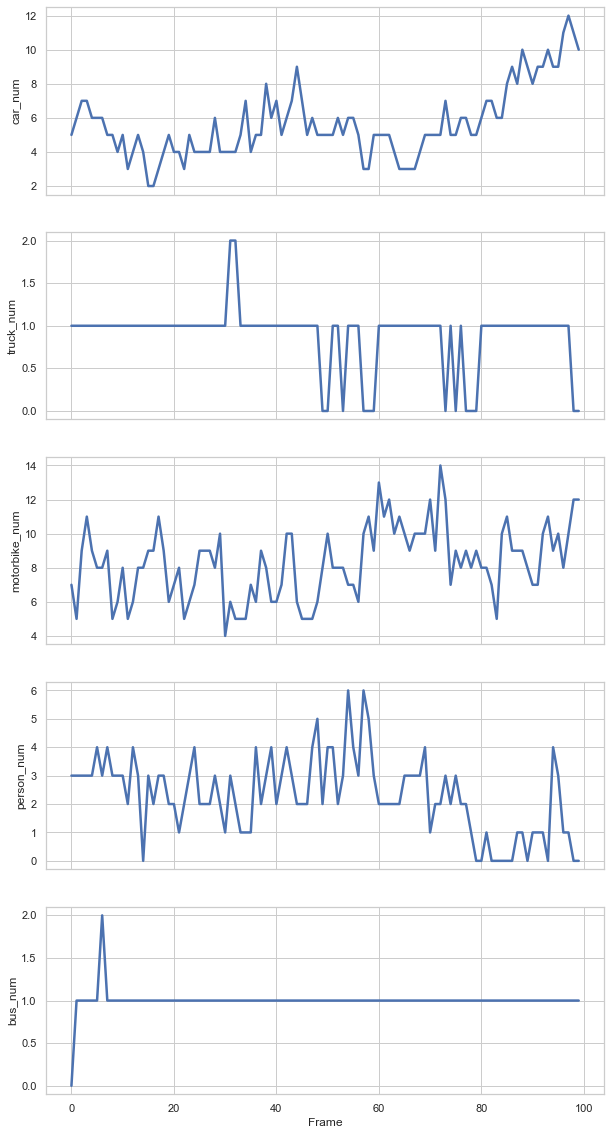

In [119]:
fig = plt.figure()
sns.set(style="whitegrid")
columns_number = len(data1_num.columns)

plot, ax = plt.subplots(columns_number, sharex='col', sharey='row', figsize=(10, 20))
for i in range(columns_number):
    plt.sca(ax[i])
    num_line1 = sns.lineplot(data=data1_num[data1_num.columns[i]].loc[0:99], linewidth=2.5, ax=ax[i]).set_ylabel(data1_num.columns[i])
    # mean_line = sns.lineplot(data=data1_mean[data1_mean.columns[i]].loc[0:99], linewidth=2.5, ax=ax[i]).set_ylabel(data1_mean.columns[i])
     
    # plt.legend(['value'])

plt.xlabel('Frame')
# plot.show()

Text(0.5, 0, 'Frame')

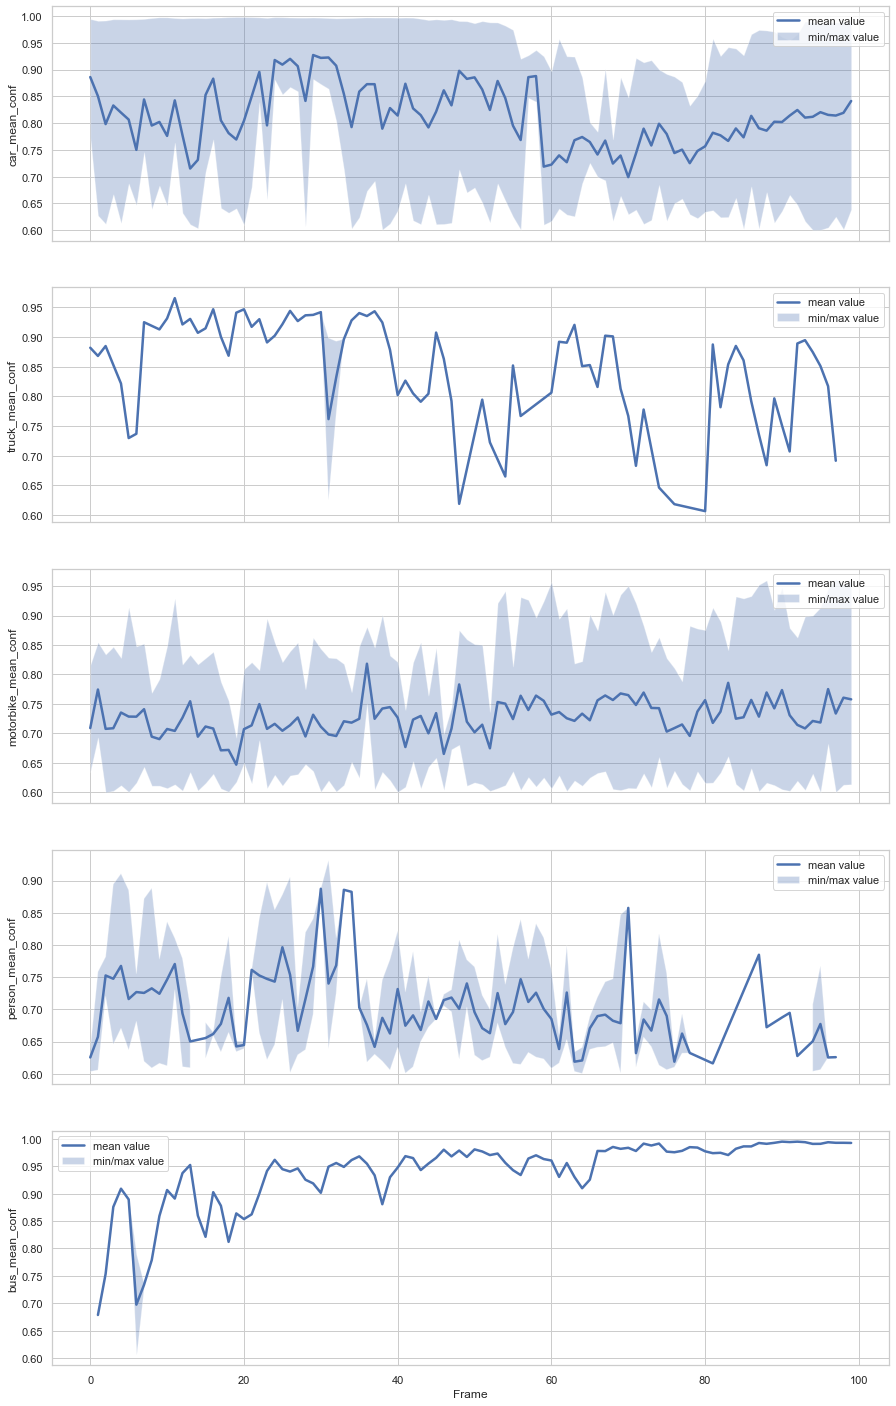

In [120]:
columns_number = len(data1_mean.columns)

plot, ax = plt.subplots(columns_number, sharex='col', sharey='row', figsize=(15, 25))
for i in range(columns_number):
    plt.sca(ax[i])
    mean_line = sns.lineplot(data=data1_mean[data1_mean.columns[i]].loc[0:99], linewidth=2.5, ax=ax[i]).set_ylabel(data1_mean.columns[i])
    minmax_line = plt.fill_between(np.arange(100), data1_min[data1_min.columns[i]].loc[0:99], 
                data1_max[data1_max.columns[i]].loc[0:99], alpha=0.3)
    plt.legend(['mean value', 'min/max value'])

plt.xlabel('Frame')
# plot.show()


In [121]:
'''
plt.figure()
data = data1_mean[data1_mean.columns[0]]
data.describe()
sns.lineplot(data=data, linewidth=2.5)
# range = data1_car_conf_by_Frame.index
delta = 0.95
plt.fill_between(data.index, data / delta, 
                 data * delta, alpha=0.3)
'''

'\nplt.figure()\ndata = data1_mean[data1_mean.columns[0]]\ndata.describe()\nsns.lineplot(data=data, linewidth=2.5)\n# range = data1_car_conf_by_Frame.index\ndelta = 0.95\nplt.fill_between(data.index, data / delta, \n                 data * delta, alpha=0.3)\n'